## Objectives

- Establish meaningful grouping of address by clustering DEX traders and LP
    - Feature Extraction:
        - with or without balances at swap time (web3py fetch balance at block)
    - Dimensionality reduction:
        - UMAP / tSNE or PCA / ICA
    - Clustering:
        - DBSCAN
        - silhouette evaluation
    **Deliverable**
    - Visualization:
        - scatter plot with color-coded returns? (TBD)

**Secondary objective: identify which group has the most profitable activity**
- Triggered Average of price by swap in/out by group of addresses

- Predict the return of the next candle based on the "history" of activity of the groups of addresses
    - Feature extracion
        - 

In [1]:
from py0xcluster.utils import web3_utils, query_utils
from py0xcluster.main_classes.classes import Pools, TradesDEX, SwapProvider
from py0xcluster.main_classes.classes import days_interval_tuples

### Getting pairs with the highest liquidity

In [2]:
uni2_pools = Pools('univ2')
pools_summary, full_results = uni2_pools.get_pools(
    min_daily_volume = 50000,
    min_daily_txns = 100,
    min_txns_per_token = 50000,
    start_date = (2022,10,25),
    end_date = (2022,11,1),
    days_batch_size = 30,
    min_days_in_ranking = 4
    )
print('nb pools:', pools_summary.shape[0])
pools_summary.head(50)

Queriying from 2022-10-25 00:00:00 to 2022-11-01 00:00:00
71 pairs dropped over 105
nb pools: 22


,pairAddress,dailyTxns,dailyVolumeUSD,reserveUSD,token0.totalLiquidity,token1.totalLiquidity,token0.txCount,token1.txCount,token0.symbol,token1.symbol,token0.id,token1.id
0,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,3468.0,8.342279e+06,9.610652e+07,1.018074e+08,3.089849e+05,7931036.0,85385017.0,USDC,WETH,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
1,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,2308.5,3.656397e+06,3.464487e+07,3.089849e+05,5.339983e+07,85385017.0,7298879.0,WETH,USDT,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7
2,0xd3d2e2692501a5c9ca623199d38826e513033a17,199.5,1.043806e+06,2.064432e+07,1.470264e+06,3.089849e+05,849309.0,85385017.0,UNI,WETH,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
3,0x9c4fe5ffd9a9fc5678cfbd93aa2d4fd684b67c4c,143.0,6.234682e+05,1.976380e+07,6.635592e+03,3.089849e+05,61099.0,85385017.0,PAXG,WETH,0x45804880de22913dafe09f4980848ece6ecbaf78,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
4,0xa478c2975ab1ea89e8196811f51a7b7ade33eb11,403.0,1.081739e+06,1.485640e+07,3.252793e+07,3.089849e+05,2557778.0,85385017.0,DAI,WETH,0x6b175474e89094c44da98b954eedeac495271d0f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
5,0x7b73644935b8e68019ac6356c40661e1bc315860,430.0,1.008471e+06,1.237519e+07,1.766158e+13,3.089849e+05,423286.0,85385017.0,ELON,WETH,0x761d38e5ddf6ccf6cf7c55759d5210750b5d60f3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
6,0x3041cbd36888becc7bbcbc0045e3b1f144466f5f,229.5,1.870714e+05,1.150044e+07,1.018074e+08,5.339983e+07,7931036.0,7298879.0,USDC,USDT,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdac17f958d2ee523a2206206994597c13d831ec7
7,0x97e1fcb93ae7267dbafad23f7b9afaa08264cfd8,119.0,3.202586e+05,5.428105e+06,1.466970e+12,3.089849e+05,195605.0,85385017.0,UFO,WETH,0x249e38ea4102d0cf8264d3701f1a0e39c4f2dc3b,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
8,0x5281e311734869c64ca60ef047fd87759397efe6,199.5,3.714319e+05,3.816776e+06,3.089849e+05,2.839710e+11,85385017.0,157143.0,WETH,CULT,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xf0f9d895aca5c8678f706fb8216fa22957685a13
9,0x6033368e4a402605294c91cf5c03d72bd96e7d8d,223.5,8.263038e+05,3.669956e+06,2.915365e+07,3.089849e+05,118323.0,85385017.0,X2Y2,WETH,0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2


### Extracting all "big" swaps from these pairs

In [ ]:
uni2_trades = TradesDEX('X')
uni2_pools.pair_addresses

all_swaps = uni2_trades.get_swaps(
    pair_addresses = uni2_pools.pair_addresses[:33],
    min_amoutUSD = 5000,
    start_date = (2022,10,28),
    end_date = (2022,11,1),
    pairs_batch_size = 3,
    days_batch_size = 15
)

In [ ]:
all_swaps

### 

In [3]:
conf = dict()
conf['QUERIES_PATH'] = r'C:\Users\phar0732\Documents\GitHub\py0xcluster\py0xcluster\queries'
conf['subgraph_url'] = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
conf['token'] = 'randomtoken'
conf['page_size'] = 1000
swaps = SwapProvider(conf)

In [4]:
swaps.get_swaps(
    pair_addresses = uni2_pools.pair_addresses[:33],
    min_amoutUSD = 5000,
    start_date = (2022,10,28),
    end_date = (2022,11,1),
    pairs_batch_size = 3,
    days_batch_size = 15
)

from 2022-10-28 00:00:00 to 2022-11-01 00:00:00
{'min_amoutUSD': 5000, 'pair_addresses': (['0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc', '0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852', '0xd3d2e2692501a5c9ca623199d38826e513033a17'],), 'start_date': (1666911600,), 'end_date': 1667260800}


AssertionError: Cannot run client.execute(query) if an asyncio loop is running. Use 'await client.execute_async(query)' instead.

In [ ]:
start_date = (2022,10,28)
end_date = (2022,11,1)

def datelim_batch_generator(start_date, end_date, days_batch_size)
 days_batch_lim = [dates_lim for dates_lim in days_interval_tuples(start_date, end_date, days_batch_size)]
        
        full_df = pd.DataFrame()
        for d_batch_nb, days_batch in enumerate(days_batch_lim):
            start_batch = query_utils.timestamp_tuple_to_unix(days_batch[0])
            end_batch = query_utils.timestamp_tuple_to_unix(days_batch[1])

In [ ]:
uni2swaps = SwapProvider(conf)
uni2swaps.get_swaps(
    pair_addresses: list = None, 
    min_amoutUSD: int = 2000, 
    start_date: tuple = None, 
    end_date: tuple = None,
    pairs_batch_size = 1,
    days_batch_size = 10,
    verbose = True
    ) 


In [15]:
all_swaps.groupby('to')['id'].count().sort_values(ascending=False).head(50)

to
0x56178a0d5f301baf6cf3e1cd53d9863437345bf9    32415
0xbeefbabeea323f07c59926295205d3b7a17e8638    17695
0x000000000dfde7deaf24138722987c9a6991e2d4     8057
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45     7429
0xf2f400c138f9fb900576263af0bc7fcde2b1b8a8     4251
0x98c3d3183c4b8a650614ad179a1a98be0a8d6b8e     3128
0x7a250d5630b4cf539739df2c5dacb4c659f2488d     2318
0x00000000ae347930bd1e7b0f35588b92280f9e75     1863
0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc     1792
0xc6093fd9cc143f9f058938868b2df2daf9a91d28     1469
0x1111111254fb6c44bac0bed2854e76f90643097d     1367
0x288931fa76d7b0482f0fd0bca9a50bf0d22b9fef     1191
0xf07704777d6bc182bf2c67fbda48913169b84983     1164
0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852      978
0xdef171fe48cf0115b1d80b88dc8eab59176fee57      946
0x9008d19f58aabd9ed0d60971565aa8510560ab41      817
0x000000000035b5e5ad9019092c665357240f594e      683
0xd249942f6d417cbfdcb792b1229353b66c790726      671
0xdef1c0ded9bec7f1a1670819833240f027b25eff      662
0x57c1e0c

<AxesSubplot: >

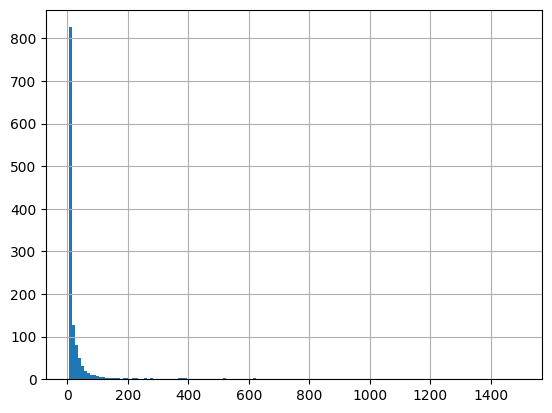

In [19]:
all_swaps.groupby('to')['id'].count().hist(bins=range(5,1500,10))

In [20]:
uni2_pools = Pools('univ3', 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3')
pools_summary, full_results = uni2_pools.get_pools(
    min_daily_volume = 50000,
    min_daily_txns = 100,
    min_txns_per_token = 50000,
    start_date = (2022,8,1),
    end_date = (2022,11,1),
    days_batch_size = 30,
    min_days_in_ranking = 4
    )
print('nb pools:', pools_summary.shape[0])
pools_summary.head(50)


Queriying from 2022-08-01 00:00:00 to 2022-08-31 00:00:00
[{'locations': [{'line': 4, 'column': 17}], 'message': 'Type `Query` has no field `pairDayDatas`'}]


KeyError: "None of [Index(['dailyTxns', 'reserveUSD', 'dailyVolumeUSD', 'token0.totalLiquidity',\n       'token0.txCount', 'token1.totalLiquidity', 'token1.txCount'],\n      dtype='object')] are in the [columns]"

In [ ]:
etherscan_API_path = r'C:\Users\phar0732\Documents\ID\etherscan\etherscan_api.csv'
etherscan_token = str(pd.read_csv(etherscan_API_path, header=None).values[0][0])
etherscan_token

address0 = '0x424a31f5caa3155437ebed0ce80169639f6689d5'
address1 = '0x728BD56A965dC3B9aDA745301C2f731599d2fe13'


In [ ]:
web3_utils.get_nonce('0x424a31f5caa3155437ebed0ce80169639f6689d5')

1